<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [62]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    precision_score, 
    plot_confusion_matrix, 
    roc_curve, 
    roc_auc_score,
    accuracy_score
)
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Исследуем данные таблицы.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Приведем названия колонок к змеиному регистру.

In [6]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

Проверим пропуски в данных

In [7]:
df.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Пропуски наблюдаются только в столбце `tenure`, который показывает сколько лет клиент сотрудничает с банком. Выдвинуть предположение, что клиенты появились недавно мы подтвердить не можем. Данных у нас не много, поэтому и удалять пропуски не стоит. Следвоательно наилучший вариант, это заполнить пропуски медианным значением.

In [8]:
df.fillna(df['tenure'].median(), inplace = True)

Проверим столбец `gender`, чтобы в нём не было лишних значений.

In [9]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

Преобразуем категориальные признаки столбца `Gender` в численные с помощью техники прямого кодирования `One-Hot Encoding`.

In [10]:
df = pd.get_dummies(df, drop_first=True, columns=['gender', 'geography'])

In [11]:
df.head()

,row_number,customer_id,surname,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,geography_Germany,geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Разделим данные на три выборки: обучающую, тестовую и валидационную.

In [12]:
target = df['exited']
features = df.drop(['exited', 'surname', 'customer_id', 'row_number'], axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=.20, 
                                                                            random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=.25, 
                                                                              random_state=12345)

Значение столбцов `сreditscore`, `balance`, `estimated_salary` довольно разбросаны, пожтому приведем их к одному масштабу.

In [13]:
numeric = ['credit_score', 'balance', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим получившие выборки на их размерность и размеры.

In [14]:
print(features_train.shape)
print(target_train.shape)

(6000, 11)
(6000,)


In [15]:
print(features_test.shape)
print(target_test.shape)

(2000, 11)
(2000,)


In [16]:
print(features_valid.shape)
print(target_valid.shape)

(2000, 11)
(2000,)


Выборки разделены верно, тестовая рана валидационной.

## Исследование задачи

**Исследовние баланса классов**

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0». 

0    0.7963
1    0.2037
Name: exited, dtype: float64


Text(0.5, 1.0, 'Проверка на дисбаланс')

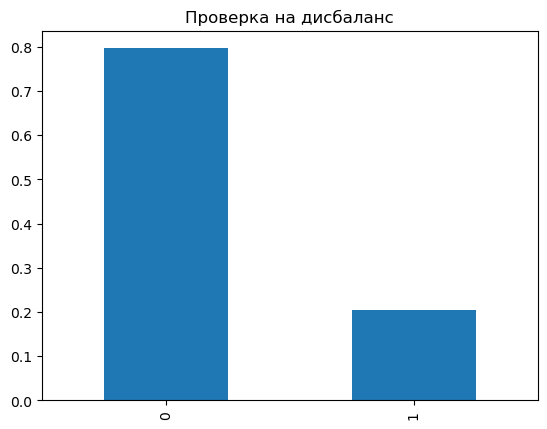

In [17]:
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Проверка на дисбаланс')

Исходя из выше увиденного, можно сделать вывод, что наблюдается довольно сильный дисбаланс 80% отражают факт того, что клиент остался и только 20%, что клиент ушёл.

Создадим коснстантную модель (1) и сравним с ней качество предсказания.

In [18]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.3518747424804285

## Проверка модели без учета дисбаланса

### Дерево решений

Подберем оптимальные значения гиперпараметров.

In [19]:
best_model = 0
best_f1 = 0
for depth in range(1,10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева:', best_depth) 
print('Качество модели: ', best_f1)

Оптимальная глубина дерева: 7
Качество модели:  0.5566037735849056


Изучим модель с оптимальными значениями.

In [20]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=7)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [21]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_tree))
print('Полнота:', recall_score(target_valid, predictions_valid_tree))
print('Точность:', precision_score(target_valid, predictions_valid_tree))
print('F1-мера:', f1_score(target_valid, predictions_valid_tree))

Правильность: 0.859
Полнота: 0.45268542199488493
Точность: 0.7224489795918367
F1-мера: 0.5566037735849056


### Случайный лес

Подберем оптимальные значения гиперпараметров.

In [22]:
best_model = 0
best_f1 = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345,
                                             n_estimators=est,
                                             max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid,predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            dest_depth = depth
            best_f1 = f1_forest

print('Оптимальное количество оценок:', best_est)
print('Оптимальная глубина дерева:', best_depth)
print('Качество модели:', best_f1)

Оптимальное количество оценок: 30
Оптимальная глубина дерева: 7
Качество модели: 0.5592105263157895


In [23]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=30, 
                                      max_depth=7)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [24]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_forest))
print('Полнота:', recall_score(target_valid, predictions_valid_forest))
print('Точность:', precision_score(target_valid, predictions_valid_forest))
print('F1-мера:', f1_score(target_valid, predictions_valid_forest))

Правильность: 0.8615
Полнота: 0.4117647058823529
Точность: 0.7740384615384616
F1-мера: 0.5375626043405676


### Логистическая регрессия

In [25]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_log.fit(features_train, target_train)
predictions_valid_log = model_log.predict(features_valid)

In [26]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_log))
print('Полнота:', recall_score(target_valid, predictions_valid_log))
print('Точность:', precision_score(target_valid, predictions_valid_log))
print('F1-мера:', f1_score(target_valid, predictions_valid_log))

Правильность: 0.8145
Полнота: 0.2071611253196931
Точность: 0.5704225352112676
F1-мера: 0.30393996247654786


In [27]:
result = [['0.86', '0.45', '0.72','0.56'],
          ['0.86','0.41','0.77','0.53'],
         ['0.81','0.21','0.57','0.31']]
model = ['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression']
value_models = pd.DataFrame(data=result,index=model, 
                            columns=['Правильность', 
                                     'Полнота', 
                                     'Точность', 
                                     'F1-мера'])
display(value_models)

,Правильность,Полнота,Точность,F1-мера
DecisionTreeClassifier,0.86,0.45,0.72,0.56
RandomForestClassifier,0.86,0.41,0.77,0.53
LogisticRegression,0.81,0.21,0.57,0.31


Наибольшая правильность у модели дерево решений и случайный лес(0.86)
 
У модели дерева решений наилучший показатель полноты(0.45).
 
Точность же лучше у модели случайный лес(0.77)
 
Оценим модель по качеству F1: дерево решений(0,56), случайный лес(0,53), логистическая регрессия(0,31).
Изучив данные можно сдлать вывод, что наулучший показатель по F1 показывает дерево решений, в то время как наибольшая правильность у модели случайный лес.


### Составим матрицу ошибок для каждой модели.

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Матрица ошибок дерево решений')

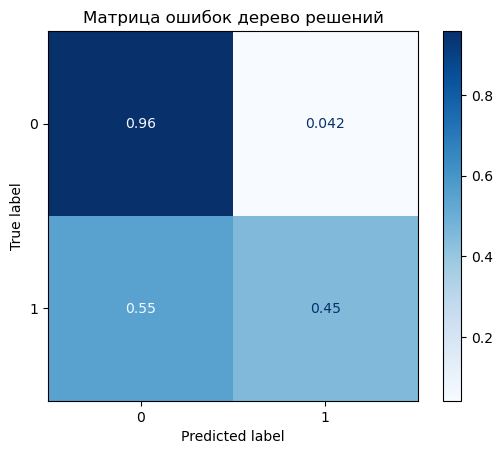

In [28]:
plot_confusion_matrix(estimator=model_tree, 
                      X=features_valid, 
                      y_true=target_valid,
                      normalize='true', 
                      cmap='Blues')
plt.title('Матрица ошибок дерево решений')

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Матрица ошибок случайный лес')

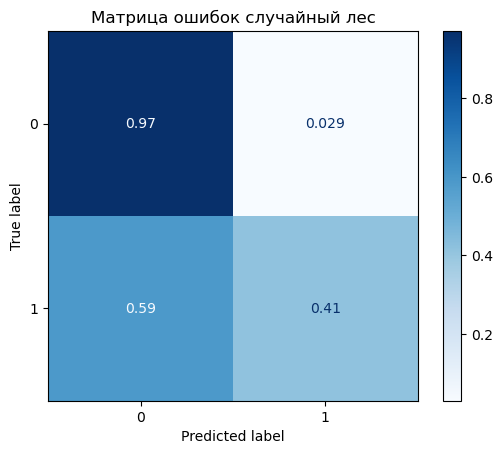

In [29]:
plot_confusion_matrix(estimator=model_forest, 
                      X=features_valid, 
                      y_true=target_valid,
                      normalize='true', 
                      cmap='Blues')
plt.title('Матрица ошибок случайный лес')

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Матрица ошибок логистическая регрессия')

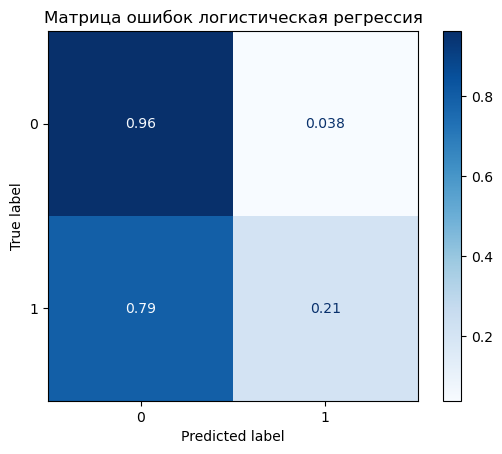

In [30]:
plot_confusion_matrix(estimator=model_log, 
                      X=features_valid, 
                      y_true=target_valid,
                      normalize='true', 
                      cmap='Blues')
plt.title('Матрица ошибок логистическая регрессия')

Исходя из представленных выше данных, мы наблюдаем довольно большой дисбаланс классов.

## Борьба с дисбалансом

### 1.Взвешивание классов.

**Дерево решений**

Подберем оптимальные значения гиперпараметров.

In [31]:
best_model = 0
best_f1 = 0
for depth in range(1,10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=depth,
                                   class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева:', best_depth) 
print('Качество модели: ', best_f1)

Оптимальная глубина дерева: 6
Качество модели:  0.5572441742654509


Изучим модель с учетом этих параметров.

In [32]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=6,
                                   class_weight='balanced')
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [33]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_tree))
print('Полнота:', recall_score(target_valid, predictions_valid_tree))
print('Точность:', precision_score(target_valid, predictions_valid_tree))
print('F1-мера:', f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc_tree)

Правильность: 0.7815
Полнота: 0.7033248081841432
Точность: 0.46140939597315433
F1-мера: 0.5572441742654509
AUC-ROC: 0.8065254745127711


**Случайный лес**

Подберем оптимальные значения гиперпараметров.

In [34]:
best_model = 0
best_f1 = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345,
                                             n_estimators=est,
                                             max_depth=depth,
                                             class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid,predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            dest_depth = depth
            best_f1 = f1_forest

print('Оптимальное количество оценок:', best_est)
print('Оптимальная глубина дерева:', best_depth)
print('Качество модели:', best_f1)

Оптимальное количество оценок: 80
Оптимальная глубина дерева: 6
Качество модели: 0.603680981595092


Изучим модель с учетом этих параметров.

In [35]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=80, 
                                      max_depth=6,
                                     class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [36]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_forest))
print('Полнота:', recall_score(target_valid, predictions_valid_forest))
print('Точность:', precision_score(target_valid, predictions_valid_forest))
print('F1-мера:', f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_forest)

Правильность: 0.7955
Полнота: 0.680306905370844
Точность: 0.48363636363636364
F1-мера: 0.565356004250797
AUC-ROC: 0.8466045374563476


**Логистическая регрессия**

In [37]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear',
                               class_weight='balanced')
model_log.fit(features_train, target_train)
predictions_valid_log = model_log.predict(features_valid)

In [38]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_log))
print('Полнота:', recall_score(target_valid, predictions_valid_log))
print('Точность:', precision_score(target_valid, predictions_valid_log))
print('F1-мера:', f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_log)

Правильность: 0.7045
Полнота: 0.6854219948849105
Точность: 0.3641304347826087
F1-мера: 0.47559893522626445
AUC-ROC: 0.7724277918803915


Сгрупируем полученные результаты.

In [39]:
result = [['0.78', '0.7', '0.46','0.55','0.8'],
          ['0.79','0.68','0.48','0.57','0.84'],
          ['0.7','0.68','0.36','0.47','0.77']]
model = ['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression']
value_models = pd.DataFrame(data=result,index=model, 
                            columns=['Правильность', 
                                     'Полнота', 
                                     'Точность', 
                                     'F1-мера',
                                     'AUC-ROC'])
display(value_models)

,Правильность,Полнота,Точность,F1-мера,AUC-ROC
DecisionTreeClassifier,0.78,0.7,0.46,0.55,0.8
RandomForestClassifier,0.79,0.68,0.48,0.57,0.84
LogisticRegression,0.7,0.68,0.36,0.47,0.77


### 2.Уменьшение выборки.

In [40]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                   [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, .25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2414, 11)
(2414,)


**Дерево решений**

Подберем оптимальные значения гиперпараметров.

In [41]:
best_model = 0
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева:', best_depth) 
print('Качество модели: ', best_f1)

Оптимальная глубина дерева: 7
Качество модели:  0.5468164794007492


Обучим модель с учетом этих параметров.

In [42]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=7)
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid_tree = model_tree.predict(features_valid)

<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Будет ошибочно использовать одновременно апсеплинг или даунсемплинг и взвешенные классы class_weight='balanced'. Мы и так доводим соотношение классов к 1:1, так что, class_weight работать не будет. Технически это не приведет к падению кода или ухудшению результатов (но и к улучшению не приведет аналитически), фактически же такой код говорит о том, что мы не понимаем механизма работы и назначения этого параметра и, соответственно, техники борьбы с дибсалансом.

</div>


In [43]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_tree))
print('Полнота:', recall_score(target_valid, predictions_valid_tree))
print('Точность:', precision_score(target_valid, predictions_valid_tree))
print('F1-мера:', f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_tree)

Правильность: 0.758
Полнота: 0.7468030690537084
Точность: 0.43131462333825704
F1-мера: 0.5468164794007492
AUC-ROC: 0.8142752007171934


**Случайный лес**

Подберем оптимальные значения гиперпараметров.

In [44]:
best_model = 0
best_f1 = 0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345,
                                             n_estimators=est,
                                             max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid,predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            dest_depth = depth
            best_f1 = f1_forest

print('Оптимальное количество оценок:', best_est)
print('Оптимальная глубина дерева:', best_depth)
print('Качество модели:', best_f1)

Оптимальное количество оценок: 20
Оптимальная глубина дерева: 7
Качество модели: 0.5771543086172345


Обучим модель с учетом этих параметров.

In [45]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=20, 
                                      max_depth=7)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)

In [46]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_forest))
print('Полнота:', recall_score(target_valid, predictions_valid_forest))
print('Точность:', precision_score(target_valid, predictions_valid_forest))
print('F1-мера:', f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_forest)

Правильность: 0.782
Полнота: 0.7084398976982097
Точность: 0.46243739565943237
F1-мера: 0.5595959595959595
AUC-ROC: 0.8424789268802881


**Логистическая регрессия**

In [47]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_log.fit(features_downsampled, target_downsampled)
predictions_valid_log = model_log.predict(features_valid)

In [48]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_log))
print('Полнота:', recall_score(target_valid, predictions_valid_log))
print('Точность:', precision_score(target_valid, predictions_valid_log))
print('F1-мера:', f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_log)

Правильность: 0.699
Полнота: 0.6956521739130435
Точность: 0.36026490066225164
F1-мера: 0.47469458987783597
AUC-ROC: 0.7736819266307328


Выведем полученные результыты в таблицу.

In [49]:
result = [['0.75', '0.74', '0.43','0.56','0.81'],
          ['0.78','0.7','0.46','0.56','0.84'],
          ['0.7','0.69','0.36','0.47','0.77']]
model = ['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression']
value_models = pd.DataFrame(data=result,index=model, 
                            columns=['Правильность', 
                                     'Полнота', 
                                     'Точность', 
                                     'F1-мера',
                                     'AUC-ROC'])
display(value_models)

,Правильность,Полнота,Точность,F1-мера,AUC-ROC
DecisionTreeClassifier,0.75,0.74,0.43,0.56,0.81
RandomForestClassifier,0.78,0.7,0.46,0.56,0.84
LogisticRegression,0.7,0.69,0.36,0.47,0.77


### 3. Увеличение выборки.

In [50]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled,target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9657, 11)
(9657,)


**Дерево решений**

Подберем оптимальные значения гиперпараметров.

In [51]:
best_model = 0
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=12345,
                                        max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева:', best_depth) 
print('Качество модели: ', best_f1)

Оптимальная глубина дерева: 6
Качество модели:  0.5572441742654509


Обучим модель с учетом этих параметров.

In [52]:
model_tree = DecisionTreeClassifier(random_state=12345,
                                   max_depth=6)
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid_tree = model_tree.predict(features_valid)

In [53]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_tree))
print('Полнота:', recall_score(target_valid, predictions_valid_tree))
print('Точность:', precision_score(target_valid, predictions_valid_tree))
print('F1-мера:', f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_tree)

Правильность: 0.7815
Полнота: 0.7033248081841432
Точность: 0.46140939597315433
F1-мера: 0.5572441742654509
AUC-ROC: 0.8065127583175837


**Случайный лес**

Подберем оптимальные значения гиперпараметров.

In [54]:
best_model = 0
best_f1 =0
for est in range(10, 101, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12345,
                                             n_estimators=est,
                                             max_depth=depth,
                                             class_weight='balanced')
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid,predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            dest_depth = depth
            best_f1 = f1_forest

print('Оптимальное количество оценок:', best_est)
print('Оптимальная глубина дерева:', best_depth)
print('Качество модели:', best_f1)

Оптимальное количество оценок: 20
Оптимальная глубина дерева: 6
Качество модели: 0.6059225512528474


Обучим модель с учетом этих параметров.

In [55]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=20, 
                                      max_depth=6)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)

In [56]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_forest))
print('Полнота:', recall_score(target_valid, predictions_valid_forest))
print('Точность:', precision_score(target_valid, predictions_valid_forest))
print('F1-мера:', f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_forest)

Правильность: 0.7945
Полнота: 0.680306905370844
Точность: 0.48188405797101447
F1-мера: 0.5641569459172853
AUC-ROC: 0.8507452485141921


**Логистическая регрессия**

In [57]:
model_log = LogisticRegression(random_state=12345,
                               solver='liblinear')
model_log.fit(features_upsampled, target_upsampled)
predictions_valid_log = model_log.predict(features_valid)

In [58]:
print('Правильность:', accuracy_score(target_valid, predictions_valid_log))
print('Полнота:', recall_score(target_valid, predictions_valid_log))
print('Точность:', precision_score(target_valid, predictions_valid_log))
print('F1-мера:', f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
 
auc_roc_log = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc_log)

Правильность: 0.701
Полнота: 0.690537084398977
Точность: 0.3614457831325301
F1-мера: 0.47451669595782076
AUC-ROC: 0.7725565433566624


Выведем полученные данные в таблицу

In [59]:
result = [['0.78', '0.7', '0.46','0.56','0.86'],
          ['0.79','0.68','0.48','0.56','0.85'],
          ['0.7','0.69','0.36','0.47','0.77']]
model = ['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression']
value_models = pd.DataFrame(data=result,index=model, 
                            columns=['Правильность', 
                                     'Полнота', 
                                     'Точность', 
                                     'F1-мера',
                                     'AUC-ROC'])
display(value_models)

,Правильность,Полнота,Точность,F1-мера,AUC-ROC
DecisionTreeClassifier,0.78,0.7,0.46,0.56,0.86
RandomForestClassifier,0.79,0.68,0.48,0.56,0.85
LogisticRegression,0.7,0.69,0.36,0.47,0.77


**Выводы:**

Для борьбы с дисбалансом мы использовали следущие методы: взвешивание классов, уменьшение и увеличение выборки.
* Уменьшение и увеличение выборки особо не влияют на изменение F1-меры.
* Наилучший результат получила модель случайного леса при возвышении классов. F1-мера была равна 0,57. Наилучшие для данной модели гиперпараметры это количество оценок равное 80, глубина дерева 6.    
* Значение AUC-ROC всегда выше F1 и колеблится в районе от 70-90%.

## Тестирование модели

Обучим выбранную нами модель на тестовой выборке.

In [60]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=80, 
                                      max_depth=6,
                                     class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_test_forest = model_forest.predict(features_test)

print('Правильность:', accuracy_score(target_test, predictions_test_forest))
print('Полнота:', recall_score(target_test, predictions_test_forest))
print('Точность:', precision_score(target_test, predictions_test_forest))
print('F1-мера:', f1_score(target_test, predictions_test_forest))

probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
 
auc_roc_forest = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC:', auc_roc_forest)

Правильность: 0.814
Полнота: 0.7423887587822015
Точность: 0.5474956822107081
F1-мера: 0.6302186878727634
AUC-ROC: 0.8632649020130392


Построим ROC-кривую для нашей модели

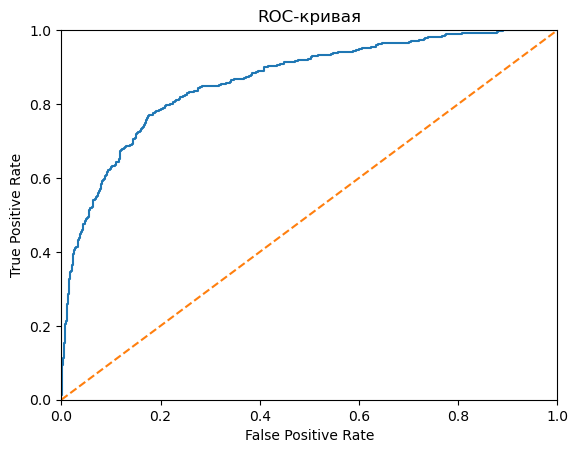

In [61]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

# Вывод по проекту

Перед тем как разделять данные на выборки была проведена подготовка данных:
 * Заполнили пропуски в данных, а именно в столбце tenure.
 * преобразовали название столбцов к нижнему регистру.
Разделели данные на выборки, избавившись от некоторых столбцов, которые не вдияют на качество обучения.

Изучили модель на качество и выявили дисбаланс классов.

Проверив модели по матрицы оштбок выявили, что у каждой из них присутсвует довольно сильный дисбаланс классов.

Были проведены 3 метода по борьбе с дисбалансом (уменьшение, увеличение выборки и возвышения классов). Исходя из проделанной работы была выявлена наилучшая модель(случайный лес) с набольшим значением F1-мерой(0,605). Значение AUC-ROC во всех моделях показывало значение выше F1-меры.

Тестирование модели случайного леса показала следущие значения основных показателей:
 * F1-мера=0,63
 * AUC-ROC=0,86